In [1]:
# Imports
import scipy
from scipy.signal import windows, welch
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from spectral_connectivity import Multitaper, Connectivity

# Generating Data

In [2]:
def generate_data(random_state = 42, duration=30):
    data = spectrum(
        sampling_rate=1000,
        duration=duration,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=False,
        plot=False
    )
    return data.time_domain.combined_signal, data.frequency_domain

data_td, data_fd = generate_data()

# Single Taper (Package)

In [3]:
from scipy.signal import periodogram
def single_taper(signal, taper_shape, fs=1000):
    freqs, psd = periodogram(x=signal, window=taper_shape, fs=fs)
    return freqs, psd # later should log freqs and 10*log(power) to get density

# Multitaper

In [4]:
def multitaper(signal, TW = 1, fs=1000):
    K = 2*TW-1 
    mt = Multitaper(time_series = signal, sampling_frequency = fs, time_halfbandwidth_product=TW, n_tapers = K)
    connectivity = Connectivity.from_multitaper(mt)
    freqs = connectivity.frequencies
    power = connectivity.power().squeeze()
    return freqs, power # later should log freqs and 10*log(power) to get density

# Example Run / Tangible Scaling Visualization Plot

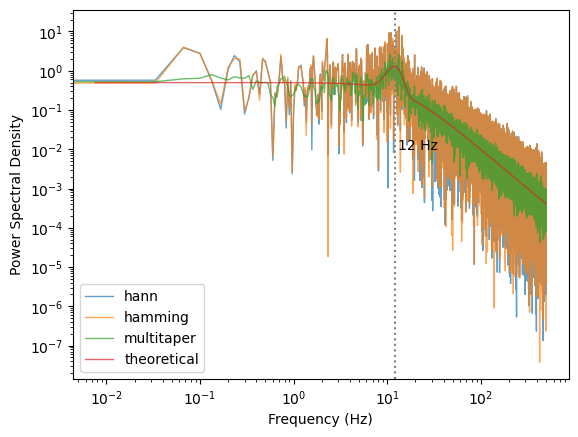

In [5]:
theoretical_freqs_pos = data_fd.frequencies[data_fd.frequencies > 0]
theoretical_psds_pos = data_fd.combined_spectrum[data_fd.frequencies > 0]

window_length = 30
freq_hann, psd_hann = single_taper(data_td, taper_shape='hann')
freq_hamming, psd_hamming = single_taper(data_td, taper_shape='hamming')
freq_mt, psd_mt = multitaper(data_td, TW=3)


plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper')
plt.loglog(theoretical_freqs_pos, theoretical_psds_pos, linewidth=1, alpha=0.7, label='theoretical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

# Bias

In [6]:
def calc_biases(empiricalPSD, theoreticalPSD, indices):
    biases = np.zeros((len(indices)))
    for i, index in enumerate(indices):
        biases[i] = empiricalPSD[index] - theoreticalPSD[index]
    return biases

In [7]:
def get_correct_theoretical_window(psd_theoretical_fd, freq_theoretical_fd, freq_empirical):
    """
    Interpolates theoretical PSD onto empirical frequency axis.
    """
    from scipy.interpolate import interp1d
    interpolator = interp1d(freq_theoretical_fd, psd_theoretical_fd, bounds_error=False, fill_value=np.nan)
    return interpolator(freq_empirical)

In [8]:
def scale_psd(psd):
    return 10 * np.log10(psd)

In [9]:
durations = [0.05, 0.1, 0.2, 0.5, 1] #seconds
frequencies_of_interest= [12, 30, 50, 80] #Hz
TW = 3
N = 10000 

for duration in durations:
    bias_hann = np.zeros([N, len(frequencies_of_interest)])
    bias_hamm = np.zeros([N, len(frequencies_of_interest)])
    bias_multitaper = np.zeros([N, len(frequencies_of_interest)])

    for random_state in range(N):
        data_td, data_fd = generate_data(duration=duration, random_state=random_state)
        theoretical_freqs_pos = data_fd.frequencies[data_fd.frequencies > 0]
        theoretical_psds_pos = scale_psd(data_fd.combined_spectrum[data_fd.frequencies > 0])

        theoretical_freqs_pos = get_correct_theoretical_window(theoretical_psds_pos, theoretical_freqs_pos, data_fd.frequencies)

        freq_hann, psd_hann = single_taper(data_td, taper_shape='hann')
        freq_hamming, psd_hamming = single_taper(data_td, taper_shape='hamming')
        freq_mt, psd_mt = multitaper(data_td, TW=3)

        psd_hann = scale_psd(psd_hann) 
        psd_hamming = scale_psd(psd_hamming)
        psd_mt = scale_psd(psd_mt)

        idx_hann = [np.argmin(np.abs(freq_hann - f)) for f in frequencies_of_interest]
        idx_hamm = [np.argmin(np.abs(freq_hamming - f)) for f in frequencies_of_interest]
        idx_mt   = [np.argmin(np.abs(freq_mt   - f)) for f in frequencies_of_interest]

        bias_hann[random_state] = calc_biases(psd_hann, theoretical_psds_pos, indices=idx_hann)
        bias_hamm[random_state] = calc_biases(psd_hamming, theoretical_psds_pos, indices=idx_hamm)
        bias_multitaper[random_state] = calc_biases(psd_mt, theoretical_psds_pos, indices=idx_mt)
    
    df_bias_hann_db = pd.DataFrame(bias_hann, columns=[f"Freq_{i}" for i in frequencies_of_interest])
    df_bias_hamm_db = pd.DataFrame(bias_hamm, columns=[f"Freq_{i}" for i in frequencies_of_interest])
    df_bias_mt_db = pd.DataFrame(bias_multitaper, columns=[f"Freq_{i}" for i in frequencies_of_interest])

    df_bias_hann_db.to_csv(f'./data/bias_hann_db {duration}s.csv', index=False)
    df_bias_hamm_db.to_csv(f'./data/bias_hamm_db {duration}s.csv', index=False)
    df_bias_mt_db.to_csv(f'./data/bias_mt_db {duration}s.csv', index=False)
        

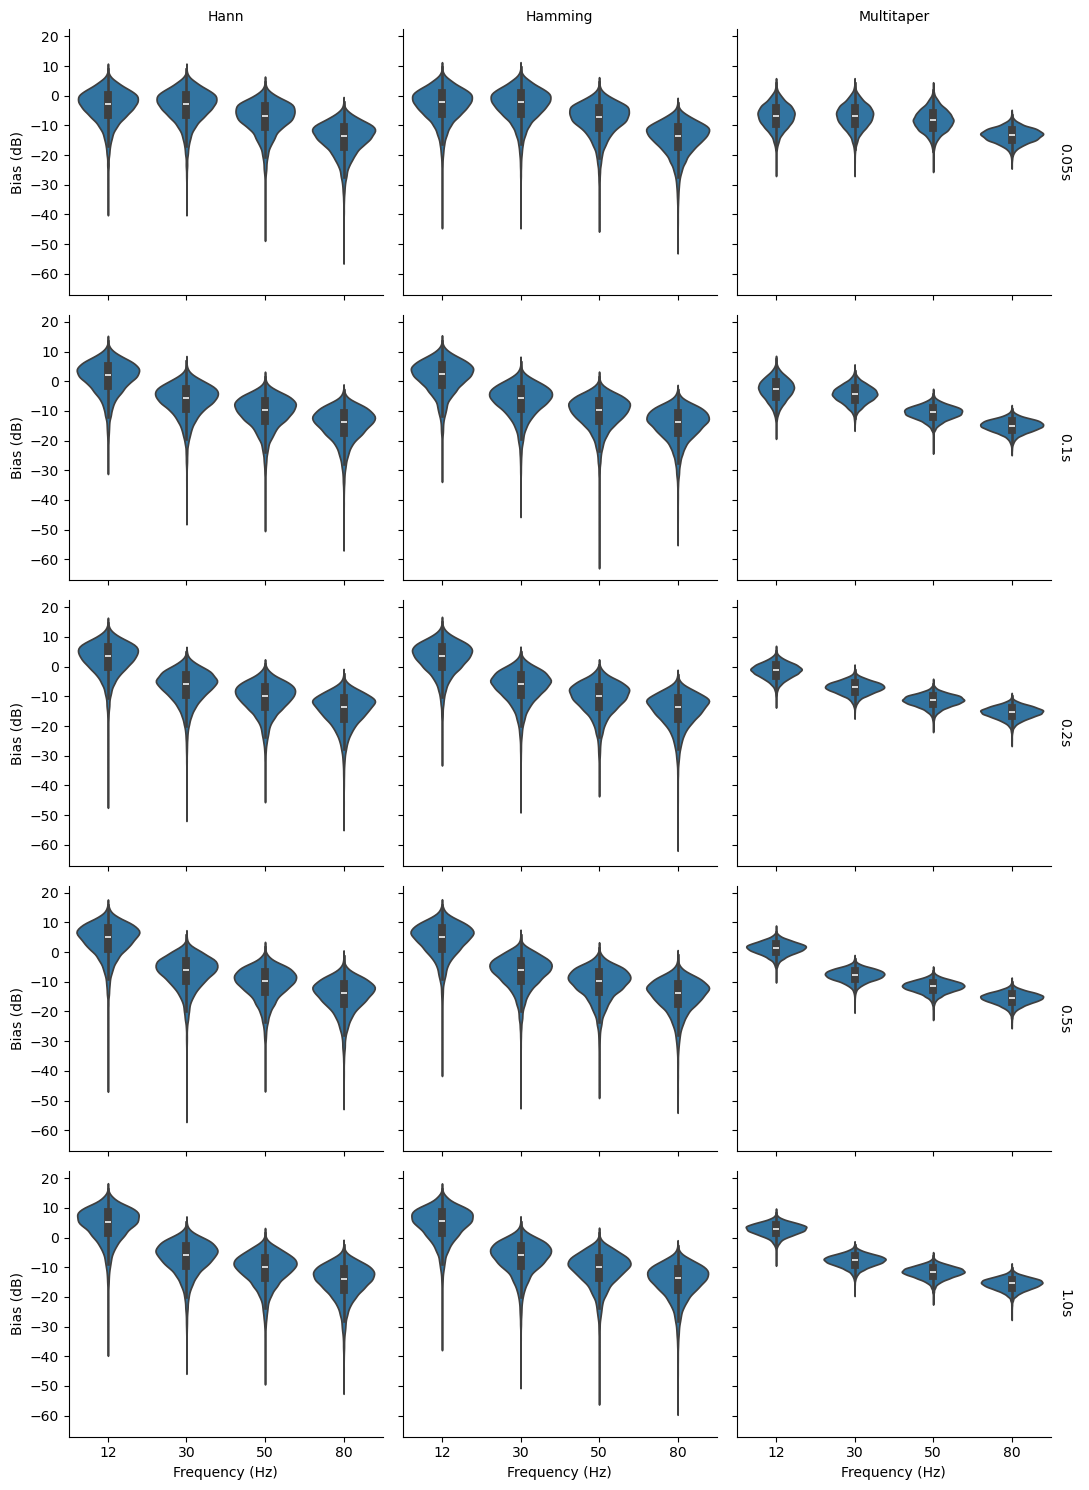

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Settings
durations = [0.05, 0.1, 0.2, 0.5, 1]
frequencies_of_interest = [12, 30, 50, 80]
tapers = ['hann', 'hamm', 'mt']

# Combine all CSVs into one DataFrame for plotting
all_data = []

for duration in durations:
    for taper in tapers:
        file_path = f'./data/bias_{taper}_db {duration}s.csv'
        if not os.path.exists(file_path):
            print(f"Skipping missing file: {file_path}")
            continue
        
        df = pd.read_csv(file_path)
        df = df.melt(var_name='Frequency', value_name='Bias_dB')  # long-form
        df['Frequency'] = df['Frequency'].str.extract(r'(\d+)').astype(int)  # e.g., Freq_12 → 12
        df['Taper'] = taper
        df['Duration'] = duration
        all_data.append(df)

# Combine into one long DataFrame
df_plot = pd.concat(all_data, ignore_index=True)

# Rename for nicer labels
taper_labels = {'hann': 'Hann', 'hamm': 'Hamming', 'mt': 'Multitaper'}
df_plot['Taper'] = df_plot['Taper'].map(taper_labels)

# Plot
g = sns.catplot(
    data=df_plot,
    x='Frequency', y='Bias_dB',
    col='Taper', row='Duration',
    kind='violin',
    sharey=True, sharex=True,
    margin_titles=True,
    height=3, aspect=1.2
)

g.set_titles(row_template='{row_name}s', col_template='{col_name}')
g.set_axis_labels("Frequency (Hz)", "Bias (dB)")
plt.tight_layout()
plt.show()


# Raw Data Processing!

https://physionet.org/content/sleep-edfx/1.0.0/

In [11]:
# import mne
# file_path = "./ST7011J0-PSG.edf"
# raw = mne.io.read_raw_edf(file_path, preload=True) # preload=True loads data into memory
# data = raw.get_data() # Access the signal data
# info = raw.info # Access header information (channels, sampling rate, etc.)

In [12]:
# import pandas as pd
# print(data.T.shape)
# df = pd.DataFrame(data.T, columns=raw.ch_names)

In [13]:
# data_real = df['EEG Fpz-Cz'][1100000:1200000] # get a certain arbitrary electrode

In [14]:
# plt.plot((df.index/100)[1100000:1200000], df['EEG Fpz-Cz'][1100000:1200000])

In [15]:
# real_data_sampling_frequency = 100 # Hz, samples/s
# window_length_options = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5] # seconds
# df_real = pd.DataFrame(columns=['window_length', 'taper_shape', 'freq, psd'])
# for window_length in window_length_options:
#     num_samples = int(window_length * real_data_sampling_frequency) # number of samples in window
#     df_real.loc[len(df_real)] = [window_length, 'hann', single_taper_no_welch(data_real, window_length=window_length, taper_shape='hann')]
#     df_real.loc[len(df_real)] = [window_length, 'hamming', single_taper_no_welch(data_real, window_length=window_length, taper_shape='hamming')]
#     df_real.loc[len(df_real)] = [window_length, 'multitaper', multitaper_package_implementation(data_real, window_length=window_length, TW=1)]

In [16]:
# df_real[['freq', 'psd']] = pd.DataFrame(df_real['freq, psd'].tolist(), index=df_real.index)

# Hann Graph

In [17]:
# plt.title('PSD representation by time window, Hann')
# for window_length in window_length_options:
#     plt.loglog(df_real[(df_real['taper_shape'] == 'hann') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
#             df_real[(df_real['taper_shape'] == 'hann') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
#             label=f"{window_length} s",
#             alpha=0.6)
# plt.legend()

# Hamming Graph

In [18]:
# plt.title('PSD representation by time window, Hamming')
# for window_length in window_length_options:
#     plt.loglog(df_real[(df_real['taper_shape'] == 'hamming') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
#             df_real[(df_real['taper_shape'] == 'hamming') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
#             label=f"{window_length} s",
#             alpha=0.6)
# plt.legend()

# Multitaper Graph!

In [19]:
# plt.title('PSD representation by time window, Multitaper')
# for window_length in window_length_options:
#     plt.loglog(df_real[(df_real['taper_shape'] == 'multitaper') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
#             df_real[(df_real['taper_shape'] == 'multitaper') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
#             label=f"{window_length} s",
#             alpha=0.6)
# plt.legend()